In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import set_figure_defaults

set_figure_defaults()

In [3]:
from replay_trajectory_classification import SortedSpikesDecoder
from src.sorted_spikes_simulation import make_simulated_run_data
from src.parameters import (
    movement_var,
    replay_speed,
    spike_model_penalty,
    place_bin_size,
    discrete_diag,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

decoder = SortedSpikesDecoder(
    movement_var=movement_var,
    replay_speed=replay_speed,
    spike_model_penalty=spike_model_penalty,
    place_bin_size=place_bin_size,
)
decoder.fit(linear_distance, spikes)

SortedSpikesDecoder(movement_var=6.0, place_bin_size=3.0, replay_speed=1,
                    spike_model_penalty=0.5)

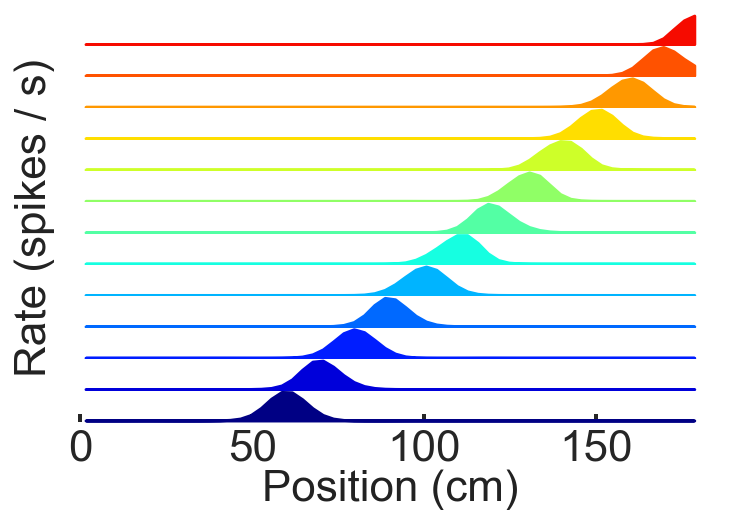

In [4]:
fig, axes = plt.subplots(13, 1, figsize=(6, 3.75))
cmap = plt.get_cmap("jet_r")
cmaplist = [cmap(i) for i in range(26, (cmap.N), (cmap.N) // 13)]

place_fields = (decoder.place_fields_ * 500).values
for ax, place_field, color in zip(axes.flat, place_fields[:, ::-1].T, cmaplist):
    ax.fill_between(
        decoder.place_bin_centers_.squeeze(),
        place_field,
        alpha=1,
        linewidth=1.5,
        clip_on=False,
        color=color,
    )
    ax.set_yticks([])

plt.xticks(range(0, 175, 50), fontsize=22)
plt.tick_params(direction="in", length=4, width=2)
plt.xlabel("Position (cm)", fontsize=22, ha="center")
axes[len(axes) // 2].set_ylabel("Rate (spikes / s)", fontsize=22, ha="center")
fig.subplots_adjust(hspace=0)
sns.despine(bottom=True, left=True, offset=5)

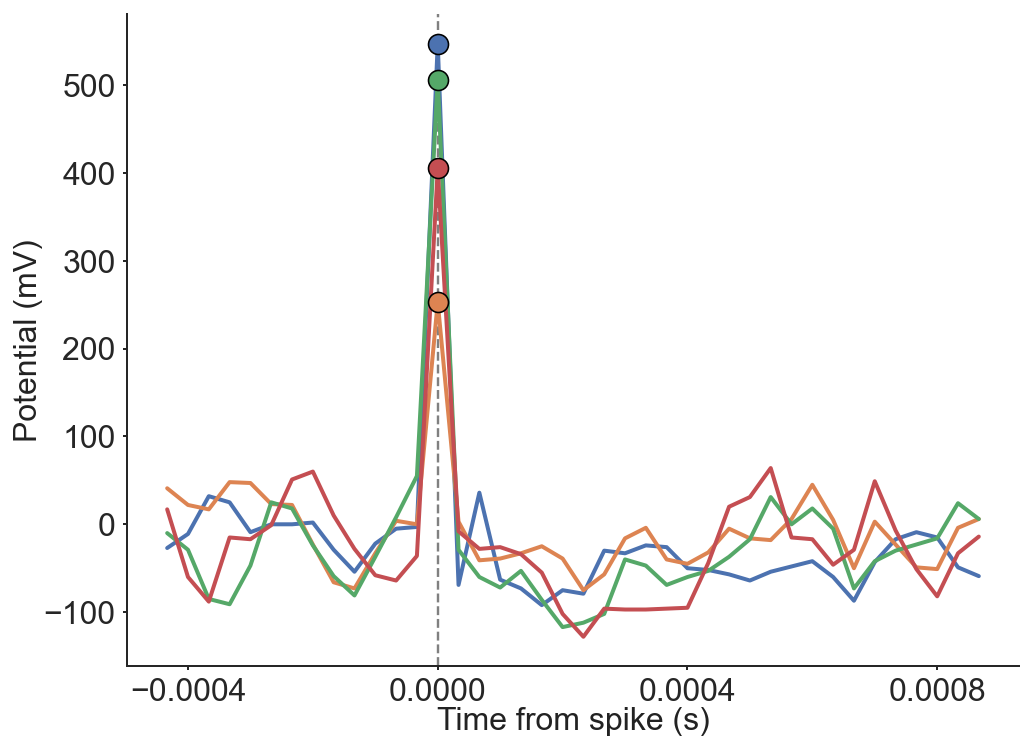

In [5]:
from scipy.io import loadmat

clip_ind = 1

clips = loadmat("clips.mat")["clips"]
clip_time = (np.arange(40) - 13) / 30_000

plt.figure(figsize=(8, 6))
plt.plot(clip_time, clips[clip_ind], zorder=10, linewidth=2)
for mark in clips[clip_ind][13]:
    plt.scatter(0.0, mark, zorder=11, s=100, edgecolor="black")
plt.axvline(0.0, color="grey", linestyle="--")
plt.xlabel("Time from spike (s)", fontsize=16)
plt.ylabel("Potential (mV)", fontsize=16)
plt.xticks([-0.0004, 0.0000, 0.0004, 0.0008])
plt.tick_params(labelsize=16)
sns.despine()

Text(0, 1.75, 'Previous\nPosition')

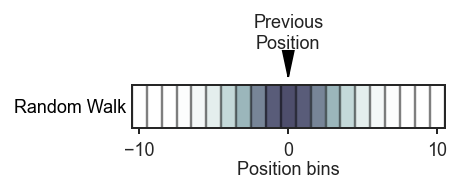

In [6]:
from scipy.stats import multivariate_normal
from src.figure_utilities import ONE_COLUMN
from src.parameters import STATE_COLORS

vmax = 0.4
states = ["Random Walk"]

fig, axes = plt.subplots(
    len(states),
    1,
    figsize=(ONE_COLUMN * 0.8, 0.4),
    sharey=True,
    constrained_layout=True,
)


bins = np.arange(-10.5, 11.5, 1)
bin_centers = bins[:-1] + np.diff(bins) / 2
transition_slice = {
    "Random Walk": multivariate_normal(cov=6).pdf(bin_centers),
    "Uniform": np.ones_like(bin_centers) / len(bin_centers),
}

x, y = np.meshgrid(bins, [0, 1])

h = axes.pcolormesh(
    x,
    y,
    transition_slice["Random Walk"][np.newaxis, :],
    cmap="bone_r",
    vmin=0.0,
    vmax=0.25,
)
axes.set_xticks([])
axes.set_yticks([])
for b in bins:
    axes.axvline(b, color="black", alpha=0.5)

name = "Random Walk"
state = name if name != "Stationary" else "Hover"
axes.set_ylabel(
    name + " ", fontsize=9, rotation=0, ha="right", va="center", color="black",
)
axes.tick_params(width=1.0, length=3.0)
axes.set_ylim((0, 1))


axes.set_xticks([-10, 0, 10])
axes.set_xlabel("Position bins")
axes.arrow(
    x=0,
    y=1.20,
    dx=0.0,
    dy=-0.015,
    color="black",
    clip_on=False,
    head_width=0.75,
    head_length=0.6,
    length_includes_head=True,
)
axes.text(0, 1.75, "Previous\nPosition", va="bottom", ha="center", fontsize=9)

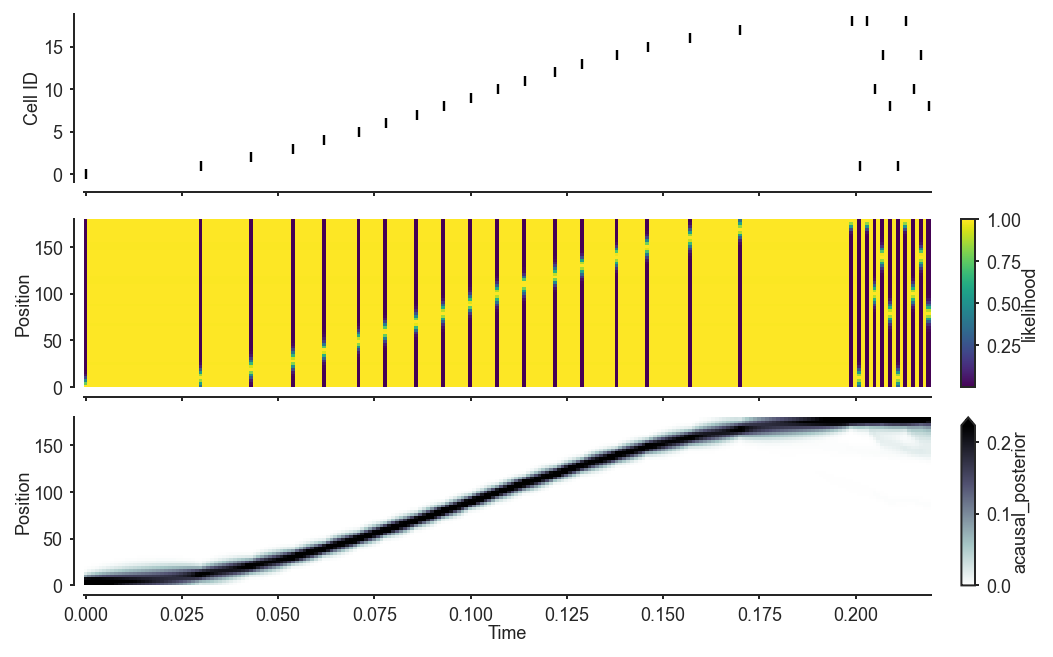

In [7]:
from src.sorted_spikes_simulation import make_continuous_replay, make_fragmented_replay

_, test_spikes1 = make_continuous_replay()
_, test_spikes2 = make_fragmented_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes2))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency


results = decoder.predict(test_spikes, time=replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].scatter(
    replay_time[spike_time_ind], neuron_ind, marker="|", clip_on=False, color="black"
)
axes[0].set_ylabel("Cell ID")

results.likelihood.plot(x="time", y="position", robust=False, ax=axes[1])
axes[1].set_ylabel("Position")
axes[1].set_xlabel("")

results.acausal_posterior.plot(
    x="time", y="position", robust=True, ax=axes[2], cmap="bone_r", vmin=0.0,
)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Position")
sns.despine(offset=5)

Text(0, 1.75, 'Previous\nPosition')

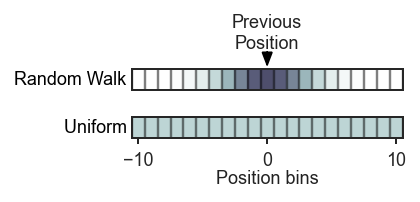

In [8]:
from scipy.stats import multivariate_normal
from src.figure_utilities import ONE_COLUMN
from src.parameters import STATE_COLORS

vmax = 0.4
states = ["Random Walk", "Uniform"]

fig, axes = plt.subplots(
    len(states),
    1,
    figsize=(ONE_COLUMN * 0.8, 1.2),
    sharey=True,
    constrained_layout=True,
)


bins = np.arange(-10.5, 11.5, 1)
bin_centers = bins[:-1] + np.diff(bins) / 2
transition_slice = {
    "Random Walk": multivariate_normal(cov=6).pdf(bin_centers),
    "Uniform": np.ones_like(bin_centers) / len(bin_centers),
}

x, y = np.meshgrid(bins, [0, 1])

for (ax, name) in zip(axes, states):
    h = ax.pcolormesh(
        x, y, transition_slice[name][np.newaxis, :], cmap="bone_r", vmin=0.0, vmax=0.25
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for b in bins:
        ax.axvline(b, color="black", alpha=0.5)
    state = name if name != "Stationary" else "Hover"
    ax.set_ylabel(
        name + " ", fontsize=9, rotation=0, ha="right", va="center", color="black",
    )
    ax.tick_params(width=1.0, length=3.0)
    ax.set_ylim((0, 1))
axes[-1].set_xticks([-10, 0, 10])
axes[-1].set_xlabel("Position bins")
axes[0].arrow(
    x=0,
    y=1.20,
    dx=0.0,
    dy=-0.015,
    color="black",
    clip_on=False,
    head_width=0.75,
    head_length=0.6,
    length_includes_head=True,
)
axes[0].text(0, 1.75, "Previous\nPosition", va="bottom", ha="center", fontsize=9)

In [9]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.sorted_spikes_simulation import make_simulated_run_data
from src.parameters import (
    movement_var,
    replay_speed,
    spike_model_penalty,
    place_bin_size,
    discrete_diag,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

continuous_transition_types = [["random_walk", "uniform"], ["uniform", "uniform"]]

classifier = SortedSpikesClassifier(
    movement_var=movement_var,
    replay_speed=replay_speed,
    spike_model_penalty=spike_model_penalty,
    place_bin_size=place_bin_size,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
)
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                    ['uniform', 'uniform']],
                       discrete_transition_diag=0.98, movement_var=6.0,
                       place_bin_size=3.0, replay_speed=1,
                       spike_model_penalty=0.5)

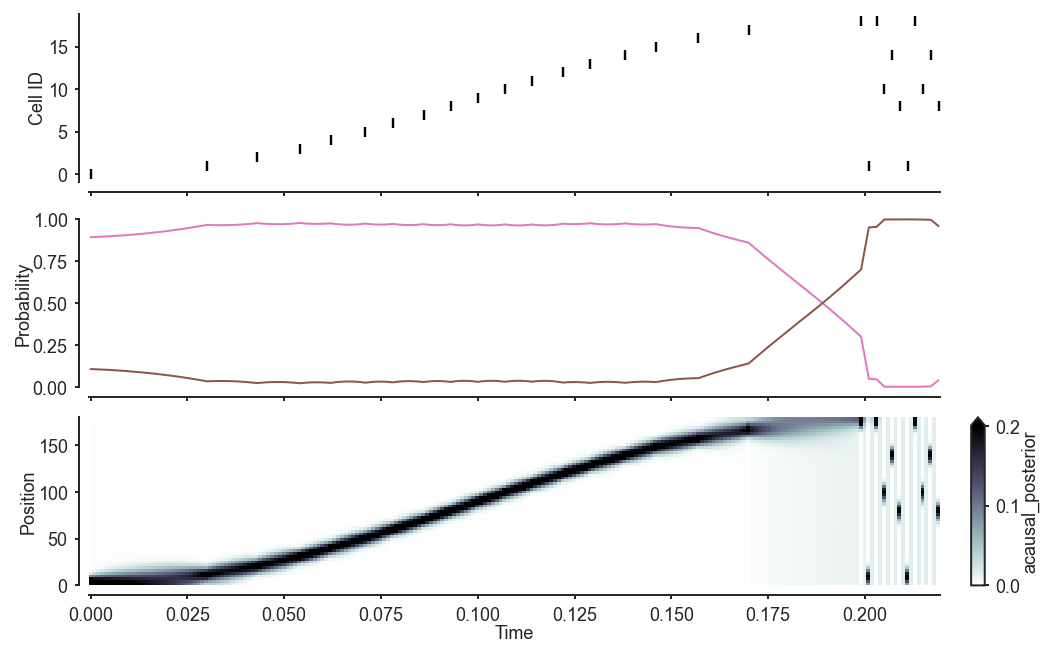

In [10]:
from src.sorted_spikes_simulation import make_continuous_replay, make_fragmented_replay

_, test_spikes1 = make_continuous_replay()
_, test_spikes2 = make_fragmented_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes2))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

results = classifier.predict(test_spikes, time=replay_time)

spike_time_ind, neuron_ind = np.nonzero(test_spikes)


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].scatter(
    replay_time[spike_time_ind], neuron_ind, marker="|", clip_on=False, color="black"
)
axes[0].set_ylabel("Cell ID")


probability = results.acausal_posterior.sum("position")
axes[1].plot(
    results.time,
    probability.sel(state="random_walk"),
    clip_on=False,
    color="tab:pink",
    linewidth=1,
)
axes[1].plot(
    results.time,
    probability.sel(state="uniform"),
    clip_on=False,
    color="tab:brown",
    linewidth=1,
)

axes[1].set_ylabel("Probability")
axes[1].set_xlabel("")
axes[1].set_ylim((0, 1))


results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=axes[2], cmap="bone_r", vmin=0.0,
)
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Position")
sns.despine(offset=5)

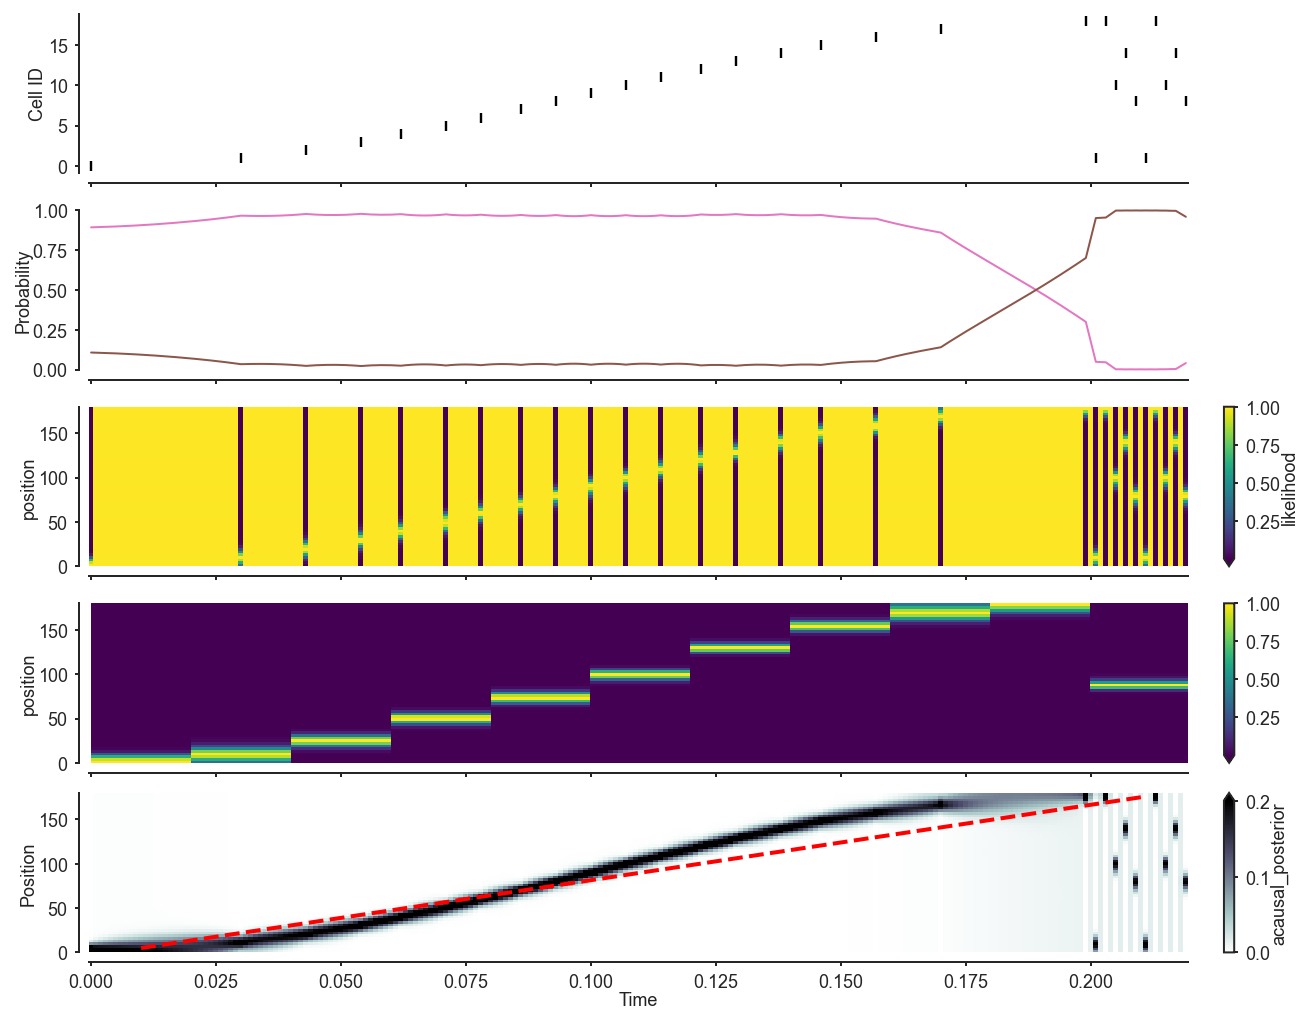

In [41]:
from src.standard_decoder import (
    isotonic_regression,
    map_estimate,
    linear_regression,
    weighted_correlation,
    detect_line_with_radon,
    predict_poisson_likelihood,
    normalize_to_posterior,
)
import xarray as xr

likelihood, time_bin_centers = predict_poisson_likelihood(
    replay_time,
    test_spikes,
    classifier.place_fields_.values,
    classifier.is_track_interior_,
    dt=0.020,
)
posterior = normalize_to_posterior(likelihood)

# Decoders
_, _, radon_prediction, radon_score = detect_line_with_radon(
    posterior, dt=1 / SAMPLING_FREQUENCY, dp=np.median(np.diff(results.position))
)
map_prediction = map_estimate(posterior, classifier.place_bin_centers_)
isotonic_prediction, isotonic_score = isotonic_regression(
    posterior, time_bin_centers, classifier.place_bin_centers_
)
_, _, linear_score, linear_prediction = linear_regression(
    posterior, classifier.place_bin_edges_, time_bin_centers
)
weighted_correlation_score = weighted_correlation(
    posterior, time_bin_centers, classifier.place_bin_centers_
)


fig, axes = plt.subplots(5, 1, sharex=True, constrained_layout=True, figsize=(9, 7))
axes[0].scatter(
    replay_time[spike_time_ind], neuron_ind, marker="|", clip_on=False, color="black"
)
axes[0].set_ylabel("Cell ID")


probability = results.acausal_posterior.sum("position")
axes[1].plot(
    results.time,
    probability.sel(state="random_walk"),
    clip_on=False,
    color="tab:pink",
    linewidth=1,
)
axes[1].plot(
    results.time,
    probability.sel(state="uniform"),
    clip_on=False,
    color="tab:brown",
    linewidth=1,
)

axes[1].set_ylabel("Probability")
axes[1].set_xlabel("")
axes[1].set_ylim((0, 1))

results.likelihood.isel(state=1).plot(
    x="time", y="position", robust=True, ax=axes[2], vmax=1.0
)
axes[2].set_title("")
axes[2].set_xlabel("")

xr.DataArray(
    likelihood,
    coords={"time": time_bin_centers, "position": results.position},
    dims=["time", "position"],
).plot(x="time", y="position", robust=True, ax=axes[3], vmax=1.0)
axes[3].set_title("")
axes[3].set_xlabel("")

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=axes[-1], cmap="bone_r", vmin=0.0,
)
axes[-1].set_xlabel("Time")
axes[-1].set_ylabel("Position")
axes[-1].plot(
    time_bin_centers, radon_prediction, linewidth=2, linestyle="--", color="red"
)
axes[-1].set_title("")

sns.despine(offset=5)

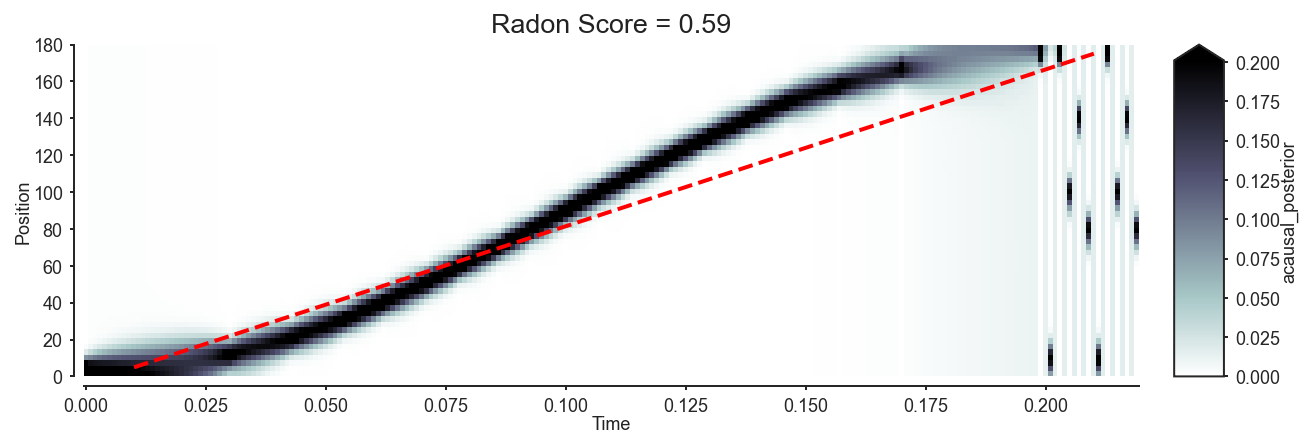

In [66]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(9, 3))

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=ax, cmap="bone_r", vmin=0.0,
)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.plot(
    time_bin_centers, radon_prediction, linewidth=2, linestyle="--", color="red",
)

ax.set_title(f"Radon Score = {radon_score:.02f}")

sns.despine(offset=5)

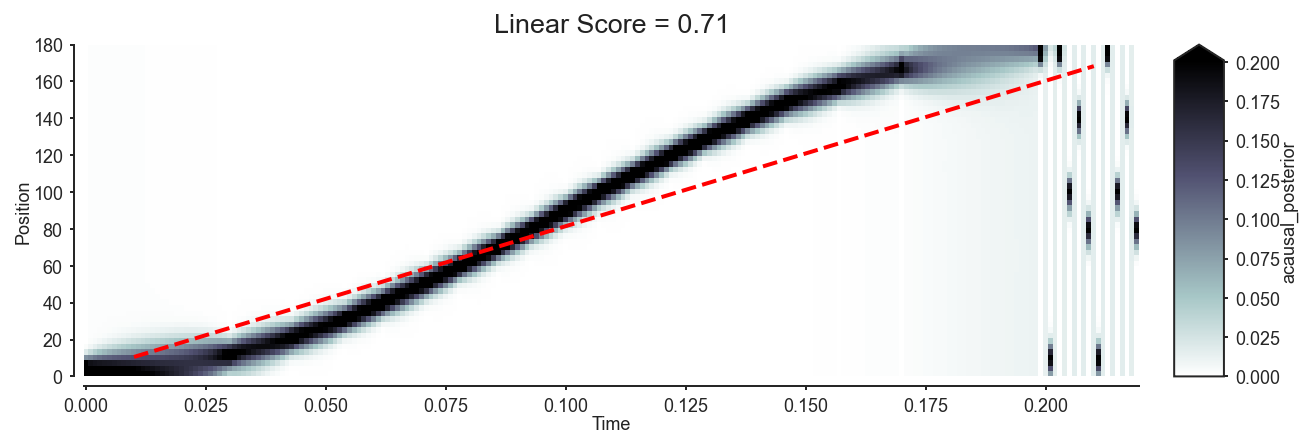

In [60]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(9, 3))

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=ax, cmap="bone_r", vmin=0.0,
)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.plot(
    time_bin_centers, linear_prediction, linewidth=2, linestyle="--", color="red",
)

ax.set_title(f"Linear Score = {linear_score:.02f}")

sns.despine(offset=5)

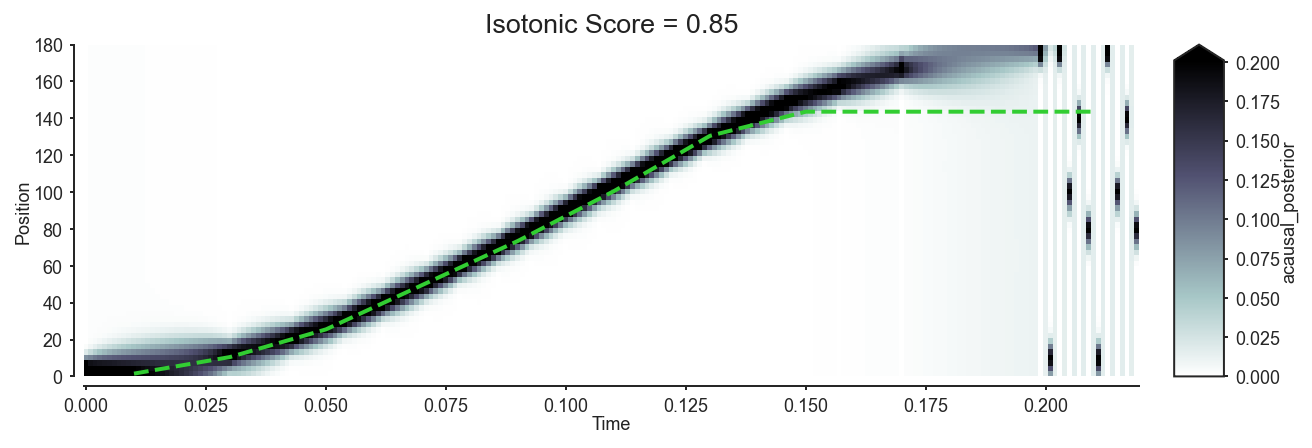

In [63]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(9, 3))

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=ax, cmap="bone_r", vmin=0.0,
)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.plot(
    time_bin_centers,
    isotonic_prediction,
    linewidth=2,
    linestyle="--",
    color="limegreen",
)
ax.set_title(f"Isotonic Score = {isotonic_score:.02f}")

sns.despine(offset=5)

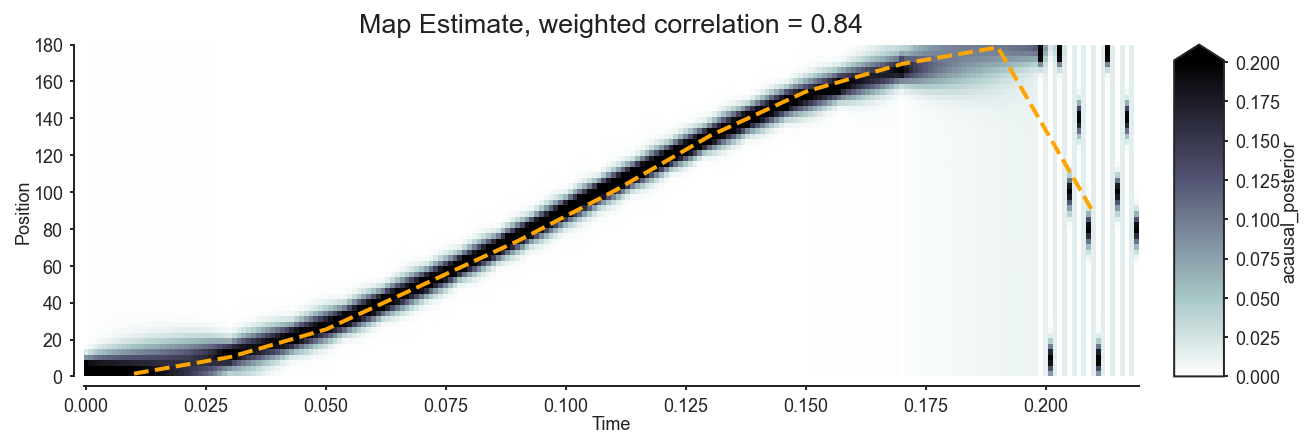

In [65]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(9, 3))

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=ax, cmap="bone_r", vmin=0.0,
)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.plot(
    time_bin_centers, map_prediction, linewidth=2, linestyle="--", color="orange",
)

ax.set_title(f"Map Estimate, weighted correlation = {weighted_correlation_score:.02f}")

sns.despine(offset=5)

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(9, 3))

results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=ax, cmap="bone_r", vmin=0.0,
)
ax.set_xlabel("Time")
ax.set_ylabel("Position")
ax.plot(time_bin_centers, radon_prediction, linewidth=2, linestyle="--", color="red")
ax.plot(time_bin_centers, radon_prediction, linewidth=2, linestyle="--", color="red")
ax.set_title("")

sns.despine(offset=5)

Text(0, 1.75, 'Previous\nPosition')

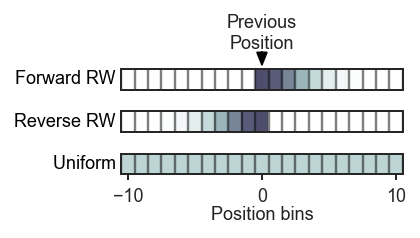

In [11]:
from scipy.stats import multivariate_normal
from src.figure_utilities import ONE_COLUMN
from src.parameters import STATE_COLORS

vmax = 0.4
states = ["Forward RW", "Reverse RW", "Uniform"]

fig, axes = plt.subplots(
    len(states),
    1,
    figsize=(ONE_COLUMN * 0.8, 1.5),
    sharey=True,
    constrained_layout=True,
)


bins = np.arange(-10.5, 11.5, 1)
bin_centers = bins[:-1] + np.diff(bins) / 2

forward_mask = np.ones_like(bin_centers)
forward_mask[:10] = 0

reverse_mask = np.ones_like(bin_centers)
reverse_mask[11:] = 0

transition_slice = {
    "Forward RW": multivariate_normal(cov=6).pdf(bin_centers) * forward_mask,
    "Reverse RW": multivariate_normal(cov=6).pdf(bin_centers) * reverse_mask,
    "Uniform": np.ones_like(bin_centers) / len(bin_centers),
}

x, y = np.meshgrid(bins, [0, 1])

for (ax, name) in zip(axes, states):
    h = ax.pcolormesh(
        x, y, transition_slice[name][np.newaxis, :], cmap="bone_r", vmin=0.0, vmax=0.25
    )
    ax.set_xticks([])
    ax.set_yticks([])
    for b in bins:
        ax.axvline(b, color="black", alpha=0.5)
    state = name if name != "Stationary" else "Hover"
    ax.set_ylabel(
        name + " ", fontsize=9, rotation=0, ha="right", va="center", color="black",
    )
    ax.tick_params(width=1.0, length=3.0)
    ax.set_ylim((0, 1))
axes[-1].set_xticks([-10, 0, 10])
axes[-1].set_xlabel("Position bins")
axes[0].arrow(
    x=0,
    y=1.20,
    dx=0.0,
    dy=-0.015,
    color="black",
    clip_on=False,
    head_width=0.75,
    head_length=0.6,
    length_includes_head=True,
)
axes[0].text(0, 1.75, "Previous\nPosition", va="bottom", ha="center", fontsize=9)